# Comparison of Basilisk and OpenFOAM flow fields

This notebook compares the velocity fields for several bubbles obtained by the following approaches:

- **Basilisk**: using a 2D axis-symmetric two-phase flow solver implemented in Basilisk, the rise velocity, shape, and velocity field have been obtained.
- **OpenFOAM (free slip)**: single phase simulations have been performed in OpenFOAM (with simpleFoam). The bubble shape and rise velocity are inputs from the Basilisk simulations (see notebook *basilisk_2D_shape_approximation_...ipynb*). At the bubble surface boundary, a free slip condition has been applied for the velocity.
- **OpenFOAM (pyTorch)**: the base setting is as before, but at the bubble surface the velocity vector as prescribed based on the output of a pyTorch model. The pyTorch model has been trained based on the tangential interface velocity obtained with the Basilisk simulations (see notebook *basilisk_2D_interface_velocity.ipynb*)

## Read Basilisk fields

In [36]:
import helper_module as hm

# Basilisk names amd simulation times
names = ["water_03_l16", "bhaga_02_l16", "bhaga_04_l16"]
times = [14, 30, 20]

data_path = "../data/"
cases = [data_path + name for name in names]
print(cases)

['../data/water_03_l16', '../data/bhaga_02_l16', '../data/bhaga_04_l16']


In [103]:
basilisk_fields = {}
U_b = []

for i, case in enumerate(cases):
    case_name = case.split("/")[-1]
    log_path = case + "/log." + case_name + ".csv"
    log = hm.Logfile(log_path)
    log.read_logfile(usecols=['time', 'u_x', 'x'])
    row = log.find_closest("time", times[i])
    U_b.append(row.u_x.values[0])
    field_path = case + "/" + case_name + "_t{:2d}.csv".format(times[i])
    basilisk_fields[case_name] = hm.CenterFieldValues2D(field_path, [0.0, row.x.values[0]], [0.0, row.u_x.values[0]])
    
print("Rise velocities:\n", U_b)

Successfully read file ../data/water_03_l16/log.water_03_l16.csv
Successfully read file ../data/water_03_l16/water_03_l16_t14.csv
Successfully read file ../data/bhaga_02_l16/log.bhaga_02_l16.csv
Successfully read file ../data/bhaga_02_l16/bhaga_02_l16_t30.csv
Successfully read file ../data/bhaga_04_l16/log.bhaga_04_l16.csv
Successfully read file ../data/bhaga_04_l16/bhaga_04_l16_t20.csv
Rise velocities:
 [3.0703601200000001, 0.54874959000000001, 0.63062704000000003]


## Read OpenFOAM fields

In [105]:
of_fields_pyto = {}
of_fields_slip = {}

for i, case in enumerate(cases):
    case_name = case.split("/")[-1]
    field_path_pyto = case + "/" + case_name + "_of_flow_pyto.csv"
    of_fields_pyto[case_name] = hm.CenterFieldValues2D(field_path_pyto, [0.0, 0.0], [0.0, 0.0], of=True)
    field_path_slip = case + "/" + case_name + "_of_flow_slip.csv"
    of_fields_slip[case_name] = hm.CenterFieldValues2D(field_path_slip, [0.0, 0.0], [0.0, 0.0], of=True)

Successfully read file ../data/water_03_l16/water_03_l16_of_flow_pyto.csv
Successfully read file ../data/water_03_l16/water_03_l16_of_flow_slip.csv
Successfully read file ../data/bhaga_02_l16/bhaga_02_l16_of_flow_pyto.csv
Successfully read file ../data/bhaga_02_l16/bhaga_02_l16_of_flow_slip.csv
Successfully read file ../data/bhaga_04_l16/bhaga_04_l16_of_flow_pyto.csv
Successfully read file ../data/bhaga_04_l16/bhaga_04_l16_of_flow_slip.csv


## Plot velocity fields

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
rc('text', usetex=True)

nx = 200
ny = 400

bbox = dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5')

output_path = "../output/"

def savefig(name):
    plt.savefig(output_path + name + ".png", bbox_inches="tight")
    plt.savefig(output_path + name + ".pdf", bbox_inches="tight")

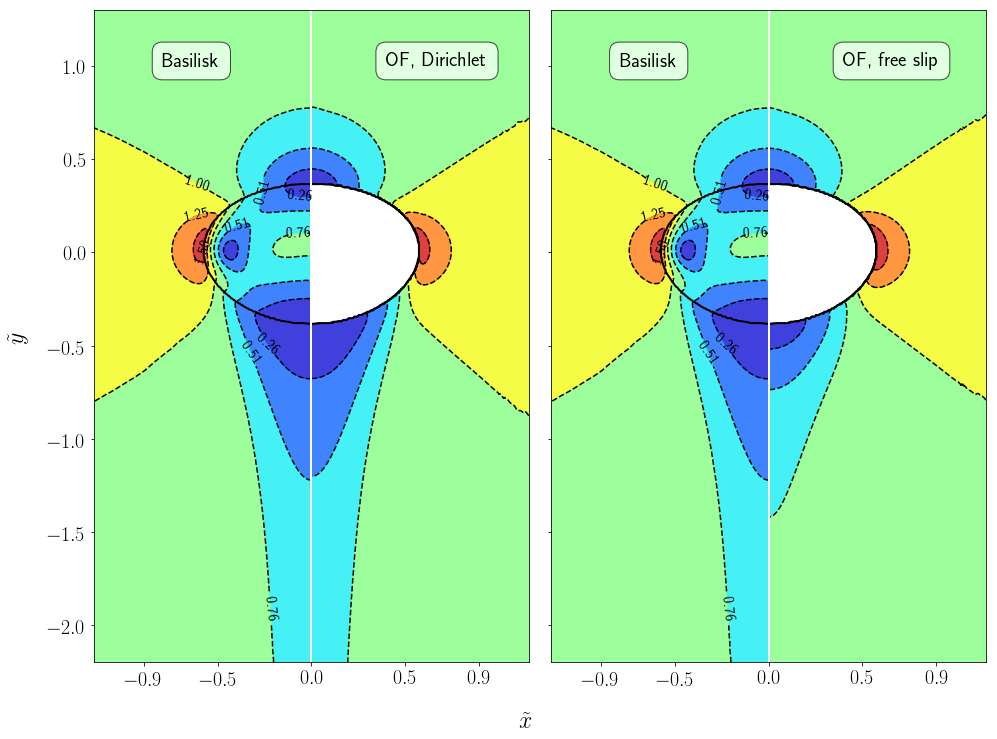

In [101]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(hm.figure_width, 12))

xi_right = np.linspace(0.0, 1.2, nx)
xi_left = np.linspace(-1.2, 0.0, nx)
xi_full = np.linspace(-1.2, 1.2, 2*nx)
yi = np.linspace(-2.2, 1.3, ny)
Xi_left, Yi_left = np.meshgrid(xi_left, yi)
Xi_right, Yi_right = np.meshgrid(xi_right, yi)
Xi_full, Yi_full = np.meshgrid(xi_full, yi)

# water_03_l16
case = "water_03_l16"
contours = []
levels = np.linspace(0.01, 1.75, 8)
labels = ["OF, Dirichlet", "OF, free slip"]

vol_f = basilisk_fields[case].interpolate_volume_fraction(Xi_full, Yi_full)
mag_U_bas = basilisk_fields[case].interpolate_velocity(Xi_left, Yi_left, True, True)
vol_f_mask = basilisk_fields[case].interpolate_volume_fraction(Xi_right, Yi_right)
vol_f_mask = np.where(vol_f_mask < 0.5, -1.0, 1.0)

for i, field in enumerate([of_fields_pyto[case], of_fields_slip[case]]):
    # basilisk results
    axarr[i].contourf(xi_left, yi, mag_U_bas/U_b[0], levels=levels, cmap='jet', alpha=hm.alpha_contour)
    contours.append(axarr[i].contour(xi_left, yi, mag_U_bas/U_b[0], levels=levels, colors='k'))
    axarr[i].clabel(contours[-1], inline=True, fontsize=hm.fontsize_contour, fmt='%1.2f')
    axarr[i].contour(xi_full, yi, vol_f, levels=[0.5], colors=['k'], linewidths=2.0)
    # OpenFOAM results
    mag_U = field.interpolate_velocity(Xi_right, Yi_right, True, True)
    mag_U *=vol_f_mask
    axarr[i].contourf(xi_right, yi, mag_U/U_b[0], levels=levels, cmap='jet', alpha=hm.alpha_contour)
    contours.append(axarr[i].contour(xi_right, yi, mag_U/U_b[0], levels=levels, colors='k'))
    axarr[i].axvline(0.0, 0.0, 1.0, color="w", lw=2, ls="-")
    axarr[i].text(-0.8, 1.0, "Basilisk", fontsize=hm.fontsize_legend, bbox=bbox)
    axarr[i].text(0.4, 1.0, labels[i], fontsize=hm.fontsize_legend, bbox=bbox)

for ax in axarr:
    ax.axis('equal')
    ax.label_outer()
    ax.set_xticks([-0.9,-0.5, 0.0, 0.5, 0.9])
    ax.tick_params(labelsize=hm.fontsize_tick)

for contour in contours:
    for line in contour.collections:
        line.set_linestyle('dashed')

fig.subplots_adjust(wspace=0.05)
fig.text(0.5, 0.05, r"$\tilde{x}$", ha='center', fontsize=hm.fontsize_label)
fig.text(0.05, 0.5, r"$\tilde{y}$", va='center', rotation='vertical', fontsize=hm.fontsize_label)

savefig("water_03_l16_of_velocity_fields")

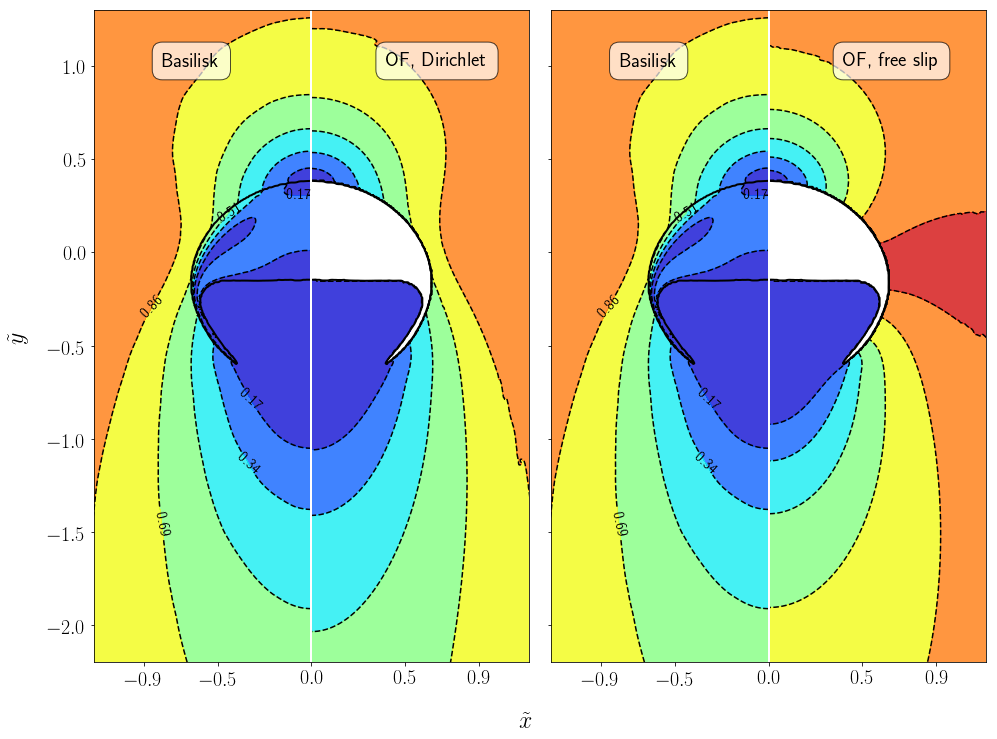

In [102]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(hm.figure_width, 12))

# bhaga_02_l16
case = "bhaga_02_l16"
contours = []
levels = np.linspace(0.0, 1.2, 8)
labels = ["OF, Dirichlet", "OF, free slip"]

vol_f = basilisk_fields[case].interpolate_volume_fraction(Xi_full, Yi_full)
mag_U_bas = basilisk_fields[case].interpolate_velocity(Xi_left, Yi_left, True, True)
vol_f_mask = basilisk_fields[case].interpolate_volume_fraction(Xi_right, Yi_right)
vol_f_mask = np.where(vol_f_mask < 0.5, -10.0, 1.0)

for i, field in enumerate([of_fields_pyto[case], of_fields_slip[case]]):
    # basilisk results
    axarr[i].contourf(xi_left, yi, mag_U_bas/U_b[1], levels=levels, cmap='jet', alpha=hm.alpha_contour)
    contours.append(axarr[i].contour(xi_left, yi, mag_U_bas/U_b[1], levels=levels, colors='k'))
    axarr[i].clabel(contours[-1], inline=True, fontsize=hm.fontsize_contour, fmt='%1.2f')
    axarr[i].contour(xi_full, yi, vol_f, levels=[0.5], colors=['k'], linewidths=2.0)
    # OpenFOAM results
    mag_U = field.interpolate_velocity(Xi_right, Yi_right, True, True)
    mag_U *=vol_f_mask
    axarr[i].contourf(xi_right, yi, mag_U/U_b[1], levels=levels, cmap='jet', alpha=hm.alpha_contour)
    contours.append(axarr[i].contour(xi_right, yi, mag_U/U_b[1], levels=levels, colors='k'))
    axarr[i].axvline(0.0, 0.0, 1.0, color="w", lw=2, ls="-")
    axarr[i].text(-0.8, 1.0, "Basilisk", fontsize=hm.fontsize_legend, bbox=bbox)
    axarr[i].text(0.4, 1.0, labels[i], fontsize=hm.fontsize_legend, bbox=bbox)

for ax in axarr:
    ax.axis('equal')
    ax.label_outer()
    ax.set_xticks([-0.9,-0.5, 0.0, 0.5, 0.9])
    ax.tick_params(labelsize=hm.fontsize_tick)

for contour in contours:
    for line in contour.collections:
        line.set_linestyle('dashed')

fig.subplots_adjust(wspace=0.05)
fig.text(0.5, 0.05, r"$\tilde{x}$", ha='center', fontsize=hm.fontsize_label)
fig.text(0.05, 0.5, r"$\tilde{y}$", va='center', rotation='vertical', fontsize=hm.fontsize_label)

savefig("bhaga_02_l16_of_velocity_fields")

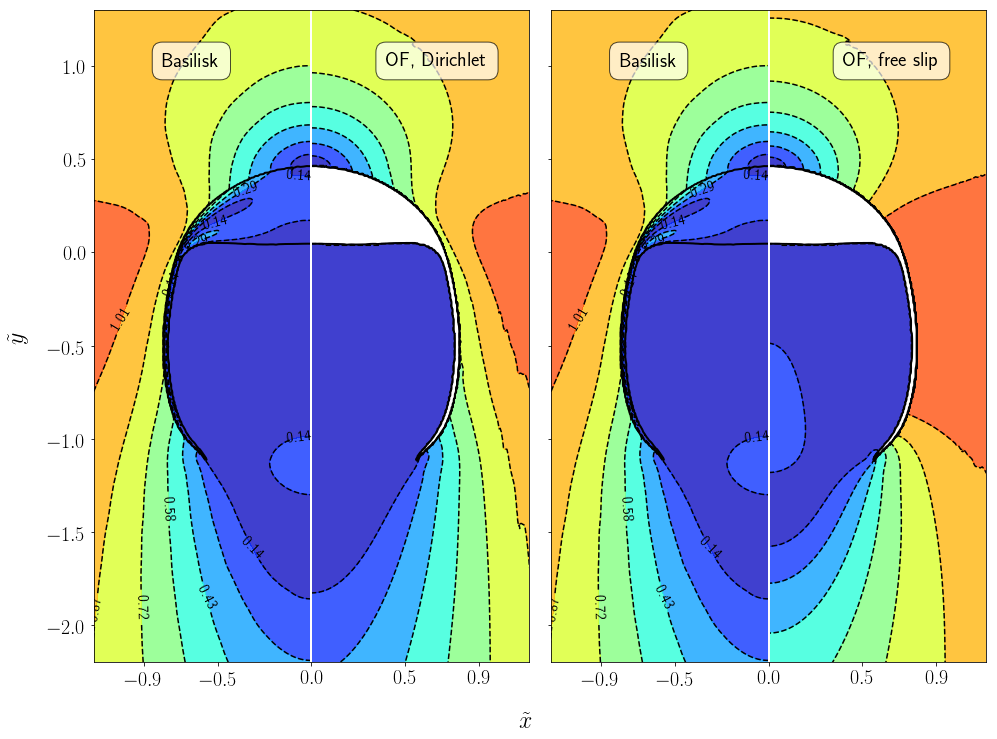

In [111]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(hm.figure_width, 12))

# bhaga_04_l16
case = "bhaga_04_l16"
contours = []
levels = np.linspace(0.0, 1.3, 10)
labels = ["OF, Dirichlet", "OF, free slip"]

vol_f = basilisk_fields[case].interpolate_volume_fraction(Xi_full, Yi_full)
mag_U_bas = basilisk_fields[case].interpolate_velocity(Xi_left, Yi_left, True, True)
vol_f_mask = basilisk_fields[case].interpolate_volume_fraction(Xi_right, Yi_right)
vol_f_mask = np.where(vol_f_mask < 0.5, -10.0, 1.0)

for i, field in enumerate([of_fields_pyto[case], of_fields_slip[case]]):
    # basilisk results
    axarr[i].contourf(xi_left, yi, mag_U_bas/U_b[2], levels=levels, cmap='jet', alpha=hm.alpha_contour)
    contours.append(axarr[i].contour(xi_left, yi, mag_U_bas/U_b[2], levels=levels, colors='k'))
    axarr[i].clabel(contours[-1], inline=True, fontsize=hm.fontsize_contour, fmt='%1.2f')
    axarr[i].contour(xi_full, yi, vol_f, levels=[0.5], colors=['k'], linewidths=2.0)
    # OpenFOAM results
    mag_U = field.interpolate_velocity(Xi_right, Yi_right, True, True)
    mag_U *=vol_f_mask
    axarr[i].contourf(xi_right, yi, mag_U/U_b[2], levels=levels, cmap='jet', alpha=hm.alpha_contour)
    contours.append(axarr[i].contour(xi_right, yi, mag_U/U_b[2], levels=levels, colors='k'))
    axarr[i].axvline(0.0, 0.0, 1.0, color="w", lw=2, ls="-")
    axarr[i].text(-0.8, 1.0, "Basilisk", fontsize=hm.fontsize_legend, bbox=bbox)
    axarr[i].text(0.4, 1.0, labels[i], fontsize=hm.fontsize_legend, bbox=bbox)

for ax in axarr:
    ax.axis('equal')
    ax.label_outer()
    ax.set_xticks([-0.9,-0.5, 0.0, 0.5, 0.9])
    ax.tick_params(labelsize=hm.fontsize_tick)

for contour in contours:
    for line in contour.collections:
        line.set_linestyle('dashed')

fig.subplots_adjust(wspace=0.05)
fig.text(0.5, 0.05, r"$\tilde{x}$", ha='center', fontsize=hm.fontsize_label)
fig.text(0.05, 0.5, r"$\tilde{y}$", va='center', rotation='vertical', fontsize=hm.fontsize_label)

savefig("bhaga_04_l16_of_velocity_fields")